# Integrating Machine Learning in Basketball

With basketball players being common household names in many basketball loving homes across the nation, players like x, y, z and many more have created a name for themselves. Although their position on a team boils down to one of 5 categories, point guard, shooting guard, small forward, power forward, and center, a lot of players have grown outside of their respective roles. Let’s integrate our own findings using machine learning algorithms to find new perspectives and meaning through the deep sea of data that basketball has evolved into.



# Setup

In [17]:
# General
import pandas as pd
import numpy as np
import os

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer

# KNN
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

# K-Means
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# Visualizations
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Data Connection
from google.cloud import bigquery
from google.colab import files
from google.colab import drive

# MISC
import warnings

In [18]:
# Set options
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 999)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Function Definitions

In [19]:
# Manually filter out features to only keep needed ones
def filter_data(input_df, columns = None):
  '''
  The function, filter_data, returns a dataframe of selected default features, unless specified, that does not contain any NA values. The categorical features
  where rows are NA are dealt with by just dropping, however with the numerical features they are dealt with using KNN Imputer. KNN Imputer uses KNN to find
  the most similar players and averaging their values in order to fill the missing ones. This method will give us the least bias results as we're not dropping
  valuable data, or filling it with just the median or average. Lastly, we are dropping any duplicate players, keeping only the first occurence of each.

  :param input_df:    dataframe of player season stats
  :param columns:     list of columns to return; if no value inputted, will filter using a default list
  :return:            dataframe that is free of NAs and duplicates with only the keeper columns
  '''

  # Keep certain columns only
  default_columns = ['playerId', 'position', 'classYr', 'height', 'mins', 'minsPg', 'fga2P40', 'fga3P40', 'ptsScoredP40', 'pfP40', 'pfdP40', 'fg2Pct', 'fg3Pct', 'efgPct', 'tsPct', 'tovPct', 'orbPct', 'drbPct', 'usagePct', 'ftaRate', 'astPct', 'fga3Rate', 'scpPctPts', 'fbptsPctPts', 'pitpPctPts', 'stlPct', 'blkPct', 'pfEff']
  if columns is None:
    features_df = input_df[default_columns]
  else:
    features_df = input_df[columns]

  # Dealing with categorical NAs by dropping
  object_cols = features_df.select_dtypes(include = ['object']).columns
  features_df = features_df.dropna(subset = object_cols)

  # Using KNN Imputer to impute the remaining NA values
  imputer = KNNImputer(n_neighbors = 25)
  features_df = features_df.set_index('playerId')
  num_cols = features_df.select_dtypes(include = ['float64', 'int64']).columns
  features_df[num_cols] = imputer.fit_transform(features_df[num_cols])

  # Filtering for minutes, 1+ 2PA, 1+ foul committed
  # Only keep players in top 67% of minutes played
  minutes_threshold = features_df['minsPg'].quantile(0.33)
  features_df = features_df[features_df['minsPg'] >= minutes_threshold]

  # Only keep players with at least 1 two-point attempt, and non NA personal foul efficiency
  features_df = features_df[~features_df['fg2Pct'].isna()]
  features_df = features_df[~features_df['pfEff'].isna()]

  # Remove duplicate players
  # Identify duplicate entries across all columns
  duplicate_players = features_df[features_df.index.duplicated(keep = False)]

  # Remove subsequent duplicates, keeping only the first occurrence
  features_df = features_df[~features_df.index.duplicated(keep = 'first')]

  return features_df

In [20]:
 # Preprocessing data by transforming object (string) columns into int columns through Label Encoding
def label_encode_data(input_df):
  '''
  The function, label_encode_data, encodes categorical columns into numerical columns. Label encoding is a technique used in machine learning and data analysis to convert categorical variables
  into numerical format. It is particularly useful when working with algorithms that require numerical input, as most machine learning models can only operate on numerical data.

  :param input_df:    dataframe of player season stats
  :return:            first value, encoded_and_original_df, returns a dataframe with the newly encoded columns under 'name_LE' and retains original categorical columns
                      second value, encoded_feature_df, returns a dataframe with encoded columns replacing the original categorical values
                      (both needed for different purposes later on)
  '''
  object_cols = input_df.select_dtypes(include=['object']).columns
  encoded_and_original_df = input_df.copy()
  encoded_feature_df = input_df.copy()

  # Transforming the categorical data into numerical ones
  le = LabelEncoder()
  for col in object_cols:
    col_name = col + "_LE"
    encoded_and_original_df[col_name] = le.fit_transform(encoded_and_original_df[col])
    encoded_feature_df[col] = le.fit_transform(encoded_feature_df[col])

  return encoded_and_original_df, encoded_feature_df

In [21]:
# Standardizes data in dataframe
def standardize_data(input_df):
  '''
  The function, standardize_data, standardizes all the data in the dataframe. Standardization creates a mean of zero and standard deviation of one which is necessary to
  ensure the scale of each column can be compared. When clustering, features with high ranges have a bigger influence clustering, creating bias.

  :param input_df:    dataframe of player season stats with no null or categorical values
  :return:            first value is the standardized data in dataframe form, second value is in an array form (e.g. get_std_df[0] or get_std_df[1])
  '''
  scaler = StandardScaler()
  std_data = scaler.fit_transform(input_df)
  std_df = pd.DataFrame(index = input_df.index, columns = input_df.columns, data = std_data)
  return std_df, std_data

In [22]:
# Creates PCA graph to find most optimal number of features and uses PCA for dimensional reduction
def create_pca_graph(input_df):
  '''
  The function, create_pca_graph, outputs a graph with the cumulative explained variance for each number of principal components using Principal Component Analysis (PCA). PCA is used to transform and lower dimensional spaces, so using this graph
  will help to determine the best way to retain the highest percentrage of info/variance. Using the elbow of the plot, will tell us the most ideal number of features to use.

  :param input_df:    dataframe of player season stats that has been standardized
  :return:            a line graph showing the cumulative variance variance against the number of principal components using PCA
  '''
  # Running PCA and determine explained variance
  pca = PCA(n_components = None)
  pca.fit(input_df)
  explained_variance = pca.explained_variance_ratio_
  cumulative_explained_variance = explained_variance.cumsum()

  # Create the graph
  plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, marker = 'o', linestyle = '--')
  plt.title('Explained Variance Ratio')
  plt.xlabel('Number of Principal Components')
  plt.ylabel('Cumulative Explained Variance')
  plt.show()

  return explained_variance

# Transforming data into n dimension using PCA (based off of PCA graph)
def get_pca_features(input_df, n = 2):
  '''
  The function, get_pca_features, uses Principal Component Analysis (PCA) to transform and lower dimensional spaces and outputs the newly transformed features.
  Using the input n, being the number of features you want, PCA will combine and drop redundant features to best fit into the number of features you want.

  :param input_df:    dataframe of player season stats that has been standardized
  :param n:           the number of features you want your data to be reduced to
  :return:            first value, pca_df, is the original df with the new PCA features in dataframe form, second value, scores_pca, is just the PCA features in an array form
  '''

  # Run PCA
  pca = PCA(n_components = n)
  pca.fit(input_df)
  scores_pca = pca.transform(input_df)
  pca_df = input_df.copy()

  # Add new PCA features into dataset
  for i in range(n):
    pca_df[f'PCA Feature {i + 1}'] = scores_pca[:,i]

  # Return dataframe with new PCA features and scores
  return pca_df, scores_pca

In [23]:
# Creates a line graph that will show the most optimal number of clusters to use for K-Means
def create_cluster_graph(pca_scores, cluster_range):
  '''
  The function, create_cluster_graph, uses the PCA score and cluster range to output the score of each cluster within the range chosen. The score is calculated through the Within Cluster Sum of Square which
  is the distance between each point and the centroid. This function graphs creates a line plot that will show the most optimal number of clusters to use for K-Means. The optimal number can be found through the elbow of the graph where
  where the graph reaches an asymptote.

  :param pca_scores:          the scores from PCA aka the reduced data
  :param cluster_range:       the highest number you want to graphed/tested (1, cluster_range)
  :return:                    a line graph that will show the WCSS of each cluster to find the most optimal number of clusters
  '''
  # Loop cluster ranges, run K-Means, append to list of WCSS
  wcss = []
  for i in range(1, cluster_range):
    kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
    kmeans_pca.fit(pca_scores)
    wcss.append(kmeans_pca.inertia_)

  # Plot and shot function
  plt.plot(range(1, cluster_range), wcss, marker = 'o', linestyle = '--')
  plt.xlabel('Number of Clusters')
  plt.ylabel('WCSS')
  plt.title('K-Means with PCA Clustering')
  plt.show()

In [24]:
# Outputs a dictionary with the original column name as the key and the wanted column name as the value (helper function for main functions)
def get_column_names(input_df, label_name):
  '''
  The function, get_column_names, takes the dataframe and outputs a dictionary with they
  1) key = original column names of the dataframe
  2) value = the corresponding column names of the specified label_name

  :param input_df:    dataframe of columns you want to find the full names for
  :param label_name:  the name of the column for name type you want (from the df, stats_key) (e.g. if you want the full name of each column instead of abbrv: "Label 3" or "Label 4")
  :return:            a dictionary containing the original column name in the key and the alternate name in the value (used for histogram names)
  '''
  columns = input_df.columns.to_list()
  # Check to see which columns exist in stats_key df (a few may not exist)
  filter = stats_key['key'].isin(columns)
  active_cols = stats_key[filter]
  # Create dictionary with original column name and new column name
  col_name_key = dict(zip(active_cols['key'], active_cols[label_name]))

  # Finding the column names that aren't in stats_key df
  no_name = list(set(columns) - set(list(col_name_key.keys())))
  # Combining those with the new names and no names, and properly capitalizing each one
  for column in col_name_key:
    if (col_name_key[column] == col_name_key[column]) == False:
      col_name_key[column] = column.capitalize()
  for column in no_name:
    col_name_key[column] = column.capitalize()
  return col_name_key

In [25]:
# Outputs the original dataframe with a new column with the cluster numbers from using K-Means
def get_kmeans_cluster(pp_df, std_df, num_clusters, show_cluster = None):
  '''
  The function, get_kmeans_cluster, takes in the preprocessed dataframe along with the standardized dataframe. It then puts in the standardized df into a K-Means model
  using num_clusters to output the dataframe with the new clusters in a column called "Labels". If the input, show_cluster, has a numerical input, the dataframe will only show the results of that cluster.
  The function outputs the new cluster labels with the original values, under pp_df while std_df, is the standardized df with the new cluster labels. Lastly, the function will output the silohuette score
  of the function. Silohuette score is quantitive measure of how well the clusters are separated, which is a good measurement since we're using a unsupervised learning model.

  :param pp_df:               dataframe that has been preprocessed but not standardized
  :param std_df:              dataframe that has been preprocessed and standardized
  :param num_clusters:        the number of clusters you want the model to output
  :param show_cluster:        the cluster number you want outputted, if None, then the whole dataframe will be outputted
  :return:                    first value, pp_df, is the unstandardized df with the new cluster labels,
                              second value, std_df, is the standardized df with the new cluster labels,
                              third value, score, is the silohuette score of the model.
  '''
  # K-Means model
  kmeans = KMeans(n_clusters = num_clusters, init = 'k-means++', random_state = 42)
  kmeans.fit(std_df)

  # Silohuette score as our measurement
  score = silhouette_score(std_df, kmeans.labels_, metric='euclidean')

  # Adding cluster label into both datasets (both needed for different purposes)
  pp_df['Label'] = kmeans.labels_ # our data with the original values now w/ label column
  std_df['Label'] = kmeans.labels_  # our standardized data now w/ label column

  # outputs only rows with initialized show_cluster in dataframe
  if show_cluster:
    filtered_pp_df = pp_df[pp_df['Label'] == show_cluster]
    filtered_std_df = std_df[std_df['Label'] == show_cluster]
    return filtered_pp_df, filtered_std_df, score
  else: # outputs all clusters in dataframe if show_cluster is NOT initialized
    return pp_df, std_df, score

In [26]:
def set_axis_style(ax, column_name):
    """
    Helper function to set the style of each axis.
    """
    ax.grid(axis='y', alpha=0.2)
    ax.set_axisbelow(True)
    ax.set_xlabel(column_name, weight="bold", size=11)
    ax.set_ylabel('Frequency', weight="bold", size=11)
    sns.despine(ax=ax, bottom=True, left=True)

def plot_histograms_for_cluster(input_df, cluster_num, col_name_key):
    """
    Helper function to plot histograms for a specified cluster across all features.
    """
    target_df = input_df.loc[input_df['Label'] == cluster_num]
    num_features = len(target_df.columns) - 1  # Exclude the label column
    num_rows, num_cols = -(-num_features // 3), 3  # Ceiling division for rows
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 4 * num_rows))
    axes = axes.flatten()

    cat_cols = input_df.select_dtypes(include=['object']).columns.tolist()

    for i, column in enumerate(input_df.columns):
        if column == 'Label' or column not in target_df:
            continue
        ax = axes[i]
        column_name = col_name_key.get(column, column)
        if column in cat_cols:
            sns.countplot(x=column, data=target_df, ax=ax, linewidth=0.9, edgecolor='black')
        elif column == "height":
            sns.histplot(target_df[column], ax=ax, bins = 5)
        else:
            sns.histplot(target_df[column], ax=ax)
        set_axis_style(ax, column_name)
        ax.set_title(f'Feature: {column}')

    fig.suptitle(f'Distribution of Cluster {cluster_num} Per Feature', weight='bold', size=15)
    fig.tight_layout(rect=[0, 0, 1, 0.987])
    plt.show()

def plot_histograms_for_feature(input_df, col_name, col_name_key):
    """
    Helper function to plot histograms for a specified feature across all clusters.
    """
    unique_labels = sorted(input_df['Label'].unique())
    num_clusters = len(unique_labels)
    num_rows, num_cols = -(-num_clusters // 3), 3  # Ceiling division for rows
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 4 * num_rows))
    axes = axes.flatten()

    max_val = max(input_df[col_name])
    min_val = min(input_df[col_name])

    for i, label in enumerate(unique_labels):
        ax = axes[i]
        column_name = col_name_key.get(col_name, col_name)
        if col_name == "height":
          sns.histplot(input_df[input_df['Label'] == label][col_name], ax=ax, bins = 5)
        else:
          sns.histplot(input_df[input_df['Label'] == label][col_name], ax=ax, binrange = (min_val, max_val))
        set_axis_style(ax, column_name)
        ax.set_title(f'Cluster Label {label}')


    fig.suptitle(f'Distribution of `{col_name}` Per Cluster', weight='bold', size=15)
    fig.tight_layout(rect=[0, 0, 1, .995])
    plt.show()

def create_kmeans_histogram(input_df, col_name=None, cluster_num=None):
    """
    The function, create_kmeans_histogram, creates a grid of histograms to show the distribution
    of values for each cluster or feature in a K-Means clustering result.
    """
    # Get column name keys for abbreviation purposes
    col_name_key = get_column_names(input_df, 'label4')

    # Validate input parameters
    if cluster_num and not isinstance(cluster_num, int):
        print("Invalid cluster number, please enter an integer!")
        return
    elif col_name and not isinstance(col_name, str):
        print("Invalid column name, please enter a string!")
        return

    # Check if the column exists in the dataframe
    if col_name and col_name not in input_df.columns:
        print(f"Column '{col_name}' does not exist in the dataframe.")
        return

    # Plot histograms based on the parameters provided
    if cluster_num is not None:
        plot_histograms_for_cluster(input_df, cluster_num, col_name_key)
    elif col_name is not None:
        plot_histograms_for_feature(input_df, col_name, col_name_key)

In [27]:
# Using KNN to get the most similar players to inputted playerId
def get_knn_similar_players(og_df, std_df, player_id, num_players):
  '''
  The function, get_knn_similar_players, takes in a dataframe to insert into a KNN model and the number of players/neighbors to insert into the model. It then generates a table with the id, player name, and all the players
  that are similar to that player along with their distance score. Using that table, we can then use the player id given, to filter the table to output the top number of players similar to the player given.

  :param og_df:           original dataframe with all features (needed to grab name of player)
  :param std_df:          dataframe that has been feature selected, label encoded and standardized, containing no NAs
  :param player_id:       the player id of the player you want to find the most similar players to
  :param num_players:     the number of similar players you want to find / number of neighbors in a KNN model
  :return:                table of the top num_players most similar to player_id with their respective names, ids, and distance score
  '''
  # Convert standardized DataFrame to a sparse matrix for nearest neighbor search
  df_feature_matrix = csr_matrix(std_df)

  # Initialize a KNN with cosine distance metric
  knn_search = NearestNeighbors(metric='cosine', algorithm='brute')
  knn_search.fit(df_feature_matrix)
  rec_list = []

  for player in std_df.index:
    # Find the nearest neighbors for the current player
    player_stats = std_df.loc[player,:].values.reshape(1,-1)
    distances, indices = knn_search.kneighbors(std_df.loc[player,:].values.reshape(1,-1), n_neighbors = num_players + 1)
    for elem in range(0, len(distances.flatten())):
      # Ignores player searched for
      if elem == 0:
        continue
      # Add recommended player
      else:
        rec_list.append([player, elem, std_df.index[indices.flatten()[elem]],distances.flatten()[elem]])

  # Convert list to dataframe
  recommendation_df = pd.DataFrame(rec_list, columns = ['search_id','rec_number','rec_id','distance_score'])

  # Map player ID to player name
  id_name_key = dict(zip(og_df['playerId'], og_df['fullName']))
  recommendation_df['search_name'] = recommendation_df['search_id'].map(id_name_key)
  recommendation_df['rec_name'] = recommendation_df['rec_id'].map(id_name_key)
  recommendation_df = recommendation_df[['search_id', 'search_name', 'rec_number', 'rec_id', 'rec_name', 'distance_score']]

  # Filter to only display inputted player_id
  return recommendation_df[recommendation_df['search_id'] == player_id]

In [28]:
def plot_single_cluster_dotplot(melted_df, cluster_num):
    """
    Helper function to plot a dotplot for a single cluster.
    """
    fig, ax = plt.subplots(figsize=(7,4))
    ax.set_axisbelow(True)
    ax.grid(alpha=0.2)
    ax.tick_params(left=False, bottom=False)
    sns.scatterplot(data=melted_df, x="variable", y="value", color='gray', alpha=0.5, s=60)
    sns.scatterplot(data=melted_df[melted_df['Label'] == cluster_num], x="variable", y="value", color='#0066CC', s=80)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.xlabel('Features', weight='bold')
    plt.ylabel('Cluster Centers', weight='bold')
    plt.title(f'Cluster {cluster_num} Performance', weight='bold')
    sns.despine(bottom=True, left=True)
    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()

def plot_all_clusters_dotplot(input_df, melted_df):
    """
    Helper function to plot dotplots for all clusters.
    """
    num_clusters = input_df['Label'].nunique()
    num_rows, num_cols = (num_clusters + 1) // 2, 2  # Organize subplots in a 2-column format
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()
    palette = sns.color_palette("husl", num_clusters)

    for i, ax in enumerate(axes):
        if i < num_clusters:
            sns.scatterplot(data=melted_df, x="variable", y="value", color='gray', ax=ax, alpha=0.5, s=60)
            sns.scatterplot(data=melted_df[melted_df['Label'] == i], x="variable", y="value", color=palette[i], ax=ax, s=80)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            ax.set_title(f'Cluster {i} Performance', weight='bold')
        else:
            ax.axis('off')

    plt.xlabel('Features', weight='bold')
    plt.ylabel('Cluster Centers', weight='bold')
    fig.suptitle('Visualizing K-Means Clusters', weight='bold', size=15)
    sns.despine()
    plt.tight_layout()
    plt.show()

def create_kmeans_cluster_dotplot(input_df, cluster_num=None):
    """
    Creates a dotplot to visualize how each cluster performs on average across each feature.
    If a cluster_num is provided, it highlights that particular cluster. If no cluster_num
    is provided, it generates a dotplot for each cluster.

    :param input_df: Dataframe with feature values and cluster labels.
    :param cluster_num: Specific cluster to highlight (int); if None, all clusters are plotted.
    :return: Dotplot(s) visualizing the cluster performance across features.
    """

    # Group by cluster label and compute mean for each feature
    agg_df = input_df.groupby('Label').mean()

    # Clip outliers to the range [-3, 3] for visualization purposes
    agg_df = agg_df.clip(lower=-3, upper=3)

    # Shorten column names for display on the graph
    col_key = get_column_names(agg_df, 'label1')
    agg_df.rename(columns=col_key, inplace=True)

    # Melt the dataframe for plotting with seaborn
    melted_df = pd.melt(agg_df.reset_index(), id_vars=['Label'],
                        value_vars=list(agg_df.columns))

    # Plot the dotplots
    if isinstance(cluster_num, int):
        # Plot for a single cluster
        plot_single_cluster_dotplot(melted_df, cluster_num)
    elif cluster_num is None:
        # Plot for all clusters
        plot_all_clusters_dotplot(input_df, melted_df)
    else:
        print("Invalid cluster number, please enter an integer or None.")

In [29]:
def create_kmeans_cluster_dotplot(input_df, cluster_num = None):
    '''
    The function create_kmeans_dotplot takes in the resulted dataframe from get_kmeans_cluster[1] with the clustered labels and outputs a dotplot.
    This dotplot showcases how each cluster (on average) performs in each feature, in comparison to other cluster through a dotplot.
    Through the input cluster_num the function will either output:
    1. a single dotplot graph highlighting the input, cluster_num
    2. if no input is put into cluster_num the default will be None, which will output k graphs, each graph highlighting per cluster

    :pararm input_df:       dataframe with the original feature values (not standardized) and the cluster labels
    :param cluster_num:     the number of the cluster (int) you want the dotplot to focus on; default is None
    :return:                a dotplot of the specified cluster or k number of dotplots
    '''
    agg_df = input_df.groupby('Label').mean()

    # Changing outliers to max of -3/3 for graphing purposes
    agg_df[(agg_df > 3)] = 3
    agg_df[(agg_df < -3)] = -3
    agg_df.reset_index()

    # Changing column names to abbrv. versions for graphing purposes
    col_key = get_column_names(agg_df, 'label1')
    for column in agg_df.columns:
        if column in col_key:
            agg_df = agg_df.rename(columns = {column: col_key[column]})

    # Transforming df to turn features into rows and one column to be able to graph
    melted_df = pd.melt(agg_df.reset_index(), id_vars = ['Label'], value_vars = agg_df.columns.to_list())

    # Creating graph
    if type(cluster_num) == int:
        fig, ax = plt.subplots()
        ax.set_axisbelow(True)  # added to make gridlines above dots
        ax.grid(alpha = 0.2)  # adds gridlines, alpha = opacity
        ax.tick_params(left=False, bottom=False)  # gets rid of tickmarks
        viz = sns.scatterplot(data = melted_df, x = "variable", y = "value", color = 'gray', alpha = 0.5) # all data points graphed
        viz.set_xticklabels(viz.get_xticklabels(), rotation=90)

        # Highlight one specific dot in a different color (e.g., red)
        highlight_color = 'black' # color of highlighted dot
        highlight_dot = melted_df[melted_df['Label'] == cluster_num]
        viz = sns.scatterplot(data = highlight_dot, x = "variable", y = "value", color = highlight_color) # only highlighted cluster graphed

        # Graph details
        plt.xlabel('Features', weight = 'bold', size = 11)
        plt.ylabel('Cluster Centers', weight = 'bold', size = 11)
        title = 'Visualizing K-Means Clusters'
        fig.suptitle(title, weight = 'bold')
        plt.title('Cluster ' + str(cluster_num), size = 11)
        sns.despine(bottom = True, left = True) # get rid of box outline of graph
        plt.show()

    elif cluster_num == None:
        num_clusters = max(input_df['Label'])
        # Get the number of columns and calculate the number of rows needed
        num_cols = 2
        num_rows = (num_clusters + 1) // 2  # Ceiling division to calculate the number of rows needed

        # Create subplots using Seaborn
        fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 4 * num_rows))  # Adjust figsize as needed
        # Flatten the 2D array of axes for easier indexing
        axes = axes.flatten()
        # Adjust color palette here
        muted_palette = sns.color_palette("husl", num_clusters + 1)

        # Plot histograms for each cluster label
        for i in range(num_clusters + 1):
          ax = axes[i]
          title = 'Cluster ' + str(i)
          viz = sns.scatterplot(data = melted_df, x = "variable", y = "value", color = 'gray', ax = ax, alpha = 0.5)
          viz.set_xticklabels(viz.get_xticklabels(), rotation=90)

          # Get the current axis
          highlight_dot = melted_df[melted_df['Label'] == i]
          viz = sns.scatterplot(data = highlight_dot, x = "variable", y = "value", color = muted_palette[i], ax = ax).set(title = title)

        # Setting x/y-axis and other graph details
        for ax in axes:
          ax.set_xlabel('Features', weight = 'bold', size = 11)
          ax.set_ylabel('Cluster Centers', weight = 'bold', size = 11)
          title = 'Visualizing K-Means Clusters'
          fig.suptitle(title, weight = 'bold', size = 15)
          ax.set_axisbelow(True)
          ax.grid(alpha = 0.2)

        ax.tick_params(left=False, bottom=False)
        sns.despine(bottom=True, left=True) # gets rid of box outline
        plt.tight_layout()  # Adjust layout for better appearance
        plt.show()
    else:
        print("Invalid cluster number, please enter an integer!")

In [30]:
def create_kmeans_player_dotplot(kmeans_df, og_df, player_id):
    '''
    The function create_kmeans_player_dotplot takes in the resulted dataframe from get_kmeans_cluster[1] with the clustered labels and outputs a dotplot.
    This dotplot showcases how each player performs in each feature, in comparison to other players within their cluster through a dotplot.

    :pararm kmeans_df:          dataframe with the original feature values (not standardized) and the cluster labels
    :param og_df:               original dataframe with all features (needed to grab name of player)
    :param player_id:           playerId of the player you want to highlight
    :return:                    a dotplot of the specified player against their cluster
    '''
    cluster_num = int(kmeans_df.loc[player_id]['Label'])
    cluster_df = kmeans_df[kmeans_df['Label'] == cluster_num].drop(['Label'], axis = 1)
    cluster_df[(cluster_df > 3)] = 3
    cluster_df[(cluster_df < -3)] = -3
    melted_df = pd.melt(cluster_df.reset_index(), id_vars = ['playerId'], value_vars = cluster_df.columns.tolist())

    # Per cluster highlight playerId
    fig, ax = plt.subplots()
    ax.set_axisbelow(True)  # makes gridlines above dots
    ax.grid(alpha = 0.2)  # adds gridlines, alpha = opacity
    ax.tick_params(left = False, bottom = False)  # gets rid of tickmarks
    viz = sns.scatterplot(data = melted_df, x = "variable", y = "value", color = 'gray', alpha = 0.5) # all data points graphed
    viz.set_xticklabels(viz.get_xticklabels(), rotation=90)

    # Highlight specific player in a different color (e.g. red)
    highlight_player = og_df[og_df['playerId'] == player_id]['fullName'].iloc[0]
    highlight_color = 'black' # color of highlighted dot
    highlight_dot = melted_df[melted_df['playerId'] == player_id]
    viz = sns.scatterplot(data = highlight_dot, x = "variable", y = "value", color = highlight_color) # only highlighted player graphed

    # Graph details
    plt.xlabel('Features', weight = 'bold', size = 11)
    plt.ylabel('Players in Cluster', weight = 'bold', size = 11)
    fig.suptitle(f'Visualizing K-Means Cluster {cluster_num}', weight = 'bold')
    plt.title(f'Highlighted Player: {highlight_player}', size = 11)
    sns.despine(bottom=True, left=True) # gets rid of box outline of graph
    plt.show()

# Loading Data

In [31]:
all_player_stats_df = pd.read_csv("player_season_stats.csv")
stats_key = pd.read_csv("data_dictionary.csv")

# K-Means

We will be using unsupervised learning to classify and cluster our data to better understand the players and their game play. One of the algorithms we will be using today will be, K-Means. K-Means is a vector quanitization method that clusters observations into the group with the nearest mean value. K-means can be useful towards finding patterns in players types, and carving our own player archetypes.



In [32]:
all_player_stats_df.head(2)

,_id,competitionId,teamId,playerId,scope,tournamentId,fullName,jerseyNum,height,position,classYr,isDraftProspect,hasImage,teamMarket,teamName,conferenceId,divisionId,isLatest,nextTeamId,nextCompetitionId,priorTeamId,priorConferenceId,priorCompetitionId,isTransfer,willTransfer,inPortal,updated,gs,gp,mins,poss,ptsScored,plusMinus,fgm,fga,fgm2,fga2,fgm3,fga3,fta,ftm,ast,orb,drb,reb,stl,blk,blkd,tov,pf,pfd,opf,pitp,scp,fbpts,minsTm,dPossTm,orbTm,drbTm,rebTm,fgmTm,fgaTm,ftaTm,tovTm,drbAgst,orbAgst,rebAgst,fgaAgst,fga3Agst,minsTmBy5,tsa,minsPg,minsP40,minsP100,ptsScoredPg,ptsScoredP40,ptsScoredP100,fgaPg,fgaP40,fgaP100,fga2Pg,fga2P40,fga2P100,fga3Pg,fga3P40,fga3P100,ftaPg,ftaP40,ftaP100,astPg,astP40,astP100,orbPg,orbP40,orbP100,drbPg,drbP40,drbP100,rebPg,rebP40,rebP100,stlPg,stlP40,stlP100,blkPg,blkP40,blkP100,pfdPg,pfdP40,pfdP100,scpPg,scpP40,scpP100,pitpPg,pitpP40,pitpP100,fbptsPg,fbptsP40,fbptsP100,blkdPg,blkdP40,blkdP100,tovPg,tovP40,tovP100,pfPg,pfP40,pfP100,opfPg,opfP40,opfP100,fgPct,fg2Pct,fg3Pct,fga3Rate,ftPct,efgPct,tsPct,ftaRate,ftmRate,orbPct,drbPct,rebPct,astTov,astPct,astRatio,blkPct,blkdPerFga,pfdPerFga,stlPct,tovPct,usagePct,pfEff,stlPerPf,blkPerPf,scpPctPts,fbptsPctPts,pitpPctPts,hkmPct,astUsage,minsThreshold,isQualified
0,33533-103680-967231-season-0,33533,103680,967231,season,0,Jared Kimbrough,1,80.000,F,Senior,False,True,Hartford,Hawks,111,1,True,NaN,36046,103680.000,18.000,30629,False,False,False,2023-04-25 18:36:00.000000 UTC,20,20,549.590,895.395,167,-225,67,140,65,132,2,8,60,31,37,26,73,99,10,24,13,51,55,66,10,114,23,7,4000.000,1300.004,169,427,596,419,1062,268,310,510,220,730,1150,430,800.000,166.400,27.480,40.000,61.380,8.350,12.155,18.651,7.000,10.189,15.636,6.600,9.607,14.742,0.400,0.582,0.893,3.000,4.367,6.701,1.850,2.693,4.132,1.300,1.892,2.904,3.650,5.313,8.153,4.950,7.205,11.057,0.500,0.728,1.117,1.200,1.747,2.680,3.300,4.804,7.371,1.150,1.674,2.569,5.700,8.297,12.732,0.350,0.509,0.782,0.650,0.946,1.452,2.550,3.712,5.696,2.750,4.003,6.143,0.500,0.728,1.117,0.479,0.492,0.250,0.057,0.517,0.486,0.502,0.429,0.221,0.056,0.164,0.109,0.725,0.168,0.145,0.049,0.093,0.471,0.011,0.235,0.212,0.618,0.182,0.436,0.138,0.042,0.683,0.060,0.789,110.460,True
1,33533-103680-1947715-season-0,33533,103680,1947715,season,0,Lorenzo Washington,2,72.000,G,Freshman,False,True,Hartford,Hawks,111,1,False,103855.000,36046,NaN,NaN,30629,False,True,True,2023-02-09 01:46:05.000000 UTC,4,22,288.270,471.083,35,-111,15,36,13,29,2,7,6,3,16,7,16,23,16,1,5,12,26,3,1,20,4,7,4400.000,1437.849,182,470,652,486,1183,306,324,554,235,789,1264,475,880.000,38.600,13.103,40.000,61.193,1.591,4.857,7.430,1.636,4.995,7.642,1.318,4.024,6.156,0.318,0.971,1.486,0.273,0.833,1.274,0.727,2.220,3.396,0.318,0.971,1.486,0.727,2.220,3.396,1.045,3.191,4.882,0.727,2.220,3.396,0.045,0.139,0.212,0.136,0.416,0.637,0.182,0.555,0.849,0.909,2.775,4.246,0.318,0.971,1.486,0.227,0.694,1.061,0.545,1.665,2.547,1.182,3.608,5.519,0.045,0.139,0.212,0.417,0.448,0.286,0.194,0.500,0.444,0.453,0.167,0.083,0.029,0.069,0.049,1.333,0.111,0.240,0.004,0.139,0.083,0.034,0.237,0.094,0.654,0.615,0.038,0.114,0.200,0.571,0.038,1.178,110.460,True


In [33]:
stats_key.head(2)

,key,tables,label1,label2,l2d,label3,label4,shortDesc,sign,unit,tipTitle,mainTip,teamTip,playerTip
0,and1,"pgps,taps,paps,tgps",And1s,And 1s,1.000,And 1s,And 1s,NaN,pos,int,And 1s,The total number of times a shot was made whil...,NaN,NaN
1,and1P100,"taps,paps",And1/100,And1/100,1.000,And 1s / 100 Poss,And 1s / 100 Poss,NaN,pos,num,And 1s / 100 Poss,The number of and 1s (made shot + foul drawn) ...,NaN,NaN


In [34]:
# if you want to "re-run everything" without data fetching, start from here!

# keep wanted features
player_stats_df__filtered = filter_data(all_player_stats_df)
player_stats_df__filtered.head(2)

,position,classYr,height,mins,minsPg,fga2P40,fga3P40,ptsScoredP40,pfP40,pfdP40,fg2Pct,fg3Pct,efgPct,tsPct,tovPct,orbPct,drbPct,usagePct,ftaRate,astPct,fga3Rate,scpPctPts,fbptsPctPts,pitpPctPts,stlPct,blkPct,pfEff
playerId,,,,,,,,,,,,,,,,,,,,,,,,,,,
967231,F,Senior,80.000,549.590,27.480,9.607,0.582,12.155,4.003,4.804,0.492,0.250,0.486,0.502,0.235,0.056,0.164,0.212,0.429,0.168,0.057,0.138,0.042,0.683,0.011,0.049,0.618
1947715,G,Freshman,72.000,288.270,13.103,4.024,0.971,4.857,3.608,0.416,0.448,0.286,0.444,0.453,0.237,0.029,0.069,0.094,0.167,0.111,0.194,0.114,0.200,0.571,0.034,0.004,0.654


In [35]:
player_stats_df__filtered.shape

(2704, 27)

In [36]:
# deal with na values and label encode categorical features
player_stats_df__label_encoded = label_encode_data(player_stats_df__filtered)[1]
player_stats_df__label_encoded.shape

(2704, 27)

In [37]:
# standardize data
player_stats_df__standardized = standardize_data(player_stats_df__label_encoded)[0]
player_stats_df__standardized.head(2)

,position,classYr,height,mins,minsPg,fga2P40,fga3P40,ptsScoredP40,pfP40,pfdP40,fg2Pct,fg3Pct,efgPct,tsPct,tovPct,orbPct,drbPct,usagePct,ftaRate,astPct,fga3Rate,scpPctPts,fbptsPctPts,pitpPctPts,stlPct,blkPct,pfEff
playerId,,,,,,,,,,,,,,,,,,,,,,,,,,,
967231,-1.184,0.385,0.738,-0.148,0.730,0.918,-1.224,-0.203,0.232,1.196,0.039,-0.414,-0.130,-0.360,1.109,0.123,0.640,0.453,0.566,0.718,-1.309,-0.135,-1.054,1.135,-0.834,1.301,0.163
1947715,0.845,-1.589,-1.458,-0.991,-1.018,-0.915,-1.083,-1.867,-0.037,-1.971,-0.389,-0.121,-0.625,-0.984,1.147,-0.590,-1.298,-1.848,-0.883,-0.069,-0.716,-0.393,0.993,0.611,1.808,-0.689,0.287


In [38]:
# final cleaned data, that has been filtered, label encoded, and standardized
player_stats_df__final = player_stats_df__standardized
player_stats_df__final.shape

(2704, 27)

## Dimensional Reduction
### Principal Component Analysis

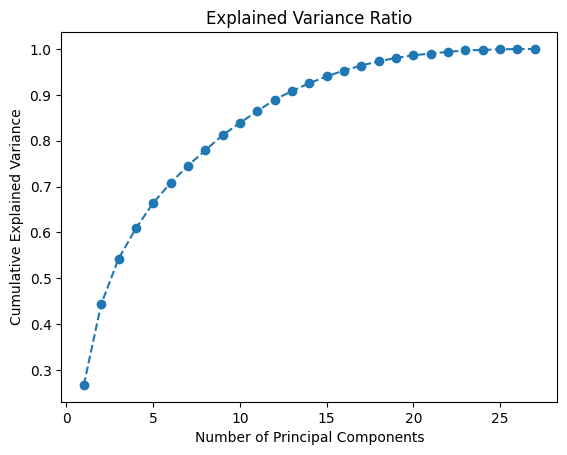

array([2.67731486e-01, 1.75467629e-01, 9.93383153e-02, 6.62432276e-02,
       5.55497537e-02, 4.36344878e-02, 3.74062812e-02, 3.36790276e-02,
       3.27529996e-02, 2.70894495e-02, 2.54730686e-02, 2.48390106e-02,
       1.89718523e-02, 1.70393236e-02, 1.49789353e-02, 1.27055165e-02,
       1.09658127e-02, 9.30054317e-03, 7.07289007e-03, 5.89639094e-03,
       3.80771356e-03, 3.70033545e-03, 3.00464480e-03, 1.24762298e-03,
       1.12321147e-03, 7.40382174e-04, 2.40088507e-04])

In [39]:
# create pca graph to get best number of features
create_pca_graph(player_stats_df__final)

In [40]:
 # using knowledge from pca graph to apply pca again for dimensional reduction
num_features = 2
pca_df, scores_pca = get_pca_features(player_stats_df__final, n = num_features)

In [41]:
# dataframe form
pca_df.head(2)

,position,classYr,height,mins,minsPg,fga2P40,fga3P40,ptsScoredP40,pfP40,pfdP40,fg2Pct,fg3Pct,efgPct,tsPct,tovPct,orbPct,drbPct,usagePct,ftaRate,astPct,fga3Rate,scpPctPts,fbptsPctPts,pitpPctPts,stlPct,blkPct,pfEff,PCA Feature 1,PCA Feature 2
playerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
967231,-1.184,0.385,0.738,-0.148,0.730,0.918,-1.224,-0.203,0.232,1.196,0.039,-0.414,-0.130,-0.360,1.109,0.123,0.640,0.453,0.566,0.718,-1.309,-0.135,-1.054,1.135,-0.834,1.301,0.163,2.758,-0.593
1947715,0.845,-1.589,-1.458,-0.991,-1.018,-0.915,-1.083,-1.867,-0.037,-1.971,-0.389,-0.121,-0.625,-0.984,1.147,-0.590,-1.298,-1.848,-0.883,-0.069,-0.716,-0.393,0.993,0.611,1.808,-0.689,0.287,-1.525,3.417


In [42]:
# array form (just the scores)
scores_pca

array([[ 2.75777044, -0.59326648],
       [-1.52548024,  3.41660456],
       [-2.25873706,  1.89621228],
       ...,
       [-0.54338867, -1.67183878],
       [ 3.04011399, -2.35848512],
       [-2.51246584, -1.3160489 ]])

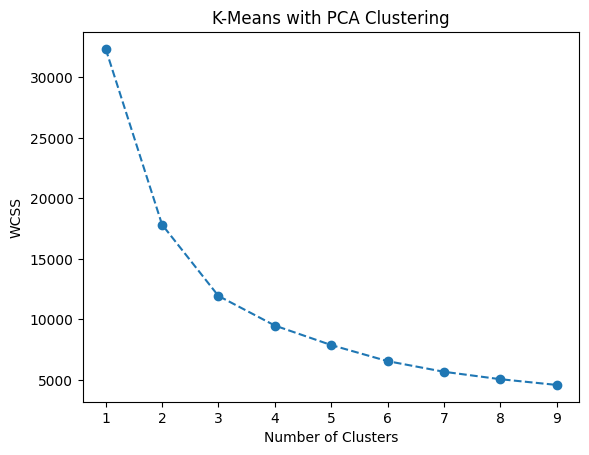

In [43]:
# create graph
create_cluster_graph(scores_pca, 10)

In [44]:
# fit kmeans
num_clusters = 10
kmeans_pca = KMeans(n_clusters = num_clusters, init = 'k-means++', random_state = 42)
kmeans_pca.fit(scores_pca) # could we fit this on the player_stats_df__final?

KMeans(n_clusters=10, random_state=42)

In [45]:
# the silhouette coefficient or silhouette score kmeans is a measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation)
score = silhouette_score(scores_pca, kmeans_pca.labels_, metric='euclidean')
score

0.323718224703027

In [46]:
# prepare data for scatterplot
reduced_df = pd.DataFrame(scores_pca)
reduced_df = reduced_df.rename(columns = {0: 'PCA 1', 1: 'PCA 2'})
reduced_df['Label'] = kmeans_pca.labels_
reduced_df

,PCA 1,PCA 2,Label
0,2.758,-0.593,8
1,-1.525,3.417,7
2,-2.259,1.896,1
3,0.906,1.649,5
4,4.762,2.300,2
...,...,...,...
2699,-2.826,-2.526,3
2700,-1.893,-3.365,3
2701,-0.543,-1.672,6
2702,3.040,-2.358,0


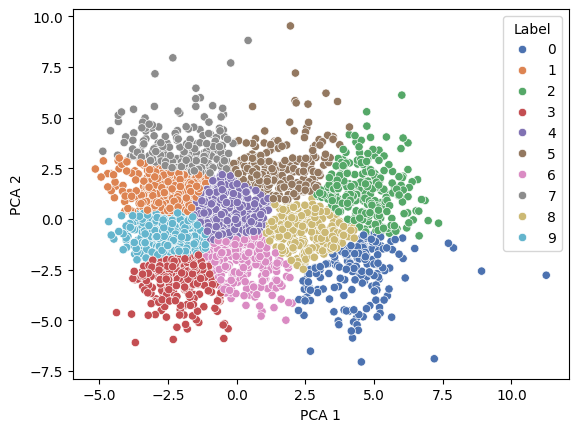

In [47]:
# dict to map clusters to colors NC: a beautiful graphic
label_colors = {
    0: sns.color_palette('deep')[0],
    1: sns.color_palette('deep')[1],
    2: sns.color_palette('deep')[2],
    3: sns.color_palette('deep')[3],
    4: sns.color_palette('deep')[4],
    5: sns.color_palette('deep')[5],
    6: sns.color_palette('deep')[6],
    7: sns.color_palette('deep')[7],
    8: sns.color_palette('deep')[8],
    9: sns.color_palette('deep')[9]
}
sns.scatterplot(data = reduced_df, x = 'PCA 1', y = 'PCA 2', hue = 'Label', palette = label_colors)
plt.show()

## Other Forms of Dimensional Reduction

When using PCA, shown above, it will try it's best to represent the data through n_components as new features. It turns our 26 features into 2 features while only capturing 40% of the data and transforming it into 2 new features. Now, I'm going to try to reduce the dimensions while keeping our original features.

### Variance Thresholding

This method will remove features with low variance, as features with low variance may not contribute much to clustering or unsupervised tasks.

In [48]:
# Set a variance threshold (e.g., 0.1)
threshold_value = 0.1

# Create a VarianceThreshold instance
selector = VarianceThreshold(threshold = threshold_value)

# Fit and transform the data
X_selected = selector.fit_transform(player_stats_df__label_encoded)

selected_filter = selector.get_support()
selected_features = player_stats_df__final.columns[selected_filter].tolist()
selected_features

['position',
 'classYr',
 'height',
 'mins',
 'minsPg',
 'fga2P40',
 'fga3P40',
 'ptsScoredP40',
 'pfP40',
 'pfdP40']

In [49]:
# Variance threshold (vt) from above to grab optimal features
vt_df = all_player_stats_df[selected_features]
vt_df.set_index(all_player_stats_df['playerId'], inplace = True)
vt_df

,position,classYr,height,mins,minsPg,fga2P40,fga3P40,ptsScoredP40,pfP40,pfdP40
playerId,,,,,,,,,,
967231,F,Senior,80.000,549.590,27.480,9.607,0.582,12.155,4.003,4.804
1947715,G,Freshman,72.000,288.270,13.103,4.024,0.971,4.857,3.608,0.416
1687493,G,Sophomore,74.000,335.430,15.973,3.697,4.412,9.063,4.889,3.578
1914079,G,Freshman,78.000,266.530,22.211,6.753,3.152,11.856,6.003,3.152
1914087,F,Freshman,77.000,256.800,13.516,6.542,0.156,9.657,5.763,4.206
...,...,...,...,...,...,...,...,...,...,...
1331908,G,Senior,75.000,1054.040,34.001,6.375,6.869,16.622,1.935,3.377
1614955,G,Junior,70.000,1043.660,33.666,10.425,5.941,19.892,2.453,3.948
1933824,F,Freshman,77.000,858.460,27.692,6.197,6.104,17.566,2.376,3.355


## K-Means Model

In [50]:
# K-Means clustering dataframe results
kmeans_df, standardized_kmeans_df, kmeans_score = get_kmeans_cluster(player_stats_df__filtered, player_stats_df__final, num_clusters = 10)

In [51]:
# Dataframe with K-Means clusters under column, Label, with the unstandardized dataset values
kmeans_df.head(2)

,position,classYr,height,mins,minsPg,fga2P40,fga3P40,ptsScoredP40,pfP40,pfdP40,fg2Pct,fg3Pct,efgPct,tsPct,tovPct,orbPct,drbPct,usagePct,ftaRate,astPct,fga3Rate,scpPctPts,fbptsPctPts,pitpPctPts,stlPct,blkPct,pfEff,Label
playerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,
967231,F,Senior,80.000,549.590,27.480,9.607,0.582,12.155,4.003,4.804,0.492,0.250,0.486,0.502,0.235,0.056,0.164,0.212,0.429,0.168,0.057,0.138,0.042,0.683,0.011,0.049,0.618,5
1947715,G,Freshman,72.000,288.270,13.103,4.024,0.971,4.857,3.608,0.416,0.448,0.286,0.444,0.453,0.237,0.029,0.069,0.094,0.167,0.111,0.194,0.114,0.200,0.571,0.034,0.004,0.654,8


In [52]:
# Dataframe with the K-Means clusters under column, Label, with the standardized dataset values
standardized_kmeans_df.head(2)

,position,classYr,height,mins,minsPg,fga2P40,fga3P40,ptsScoredP40,pfP40,pfdP40,fg2Pct,fg3Pct,efgPct,tsPct,tovPct,orbPct,drbPct,usagePct,ftaRate,astPct,fga3Rate,scpPctPts,fbptsPctPts,pitpPctPts,stlPct,blkPct,pfEff,Label
playerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,
967231,-1.184,0.385,0.738,-0.148,0.730,0.918,-1.224,-0.203,0.232,1.196,0.039,-0.414,-0.130,-0.360,1.109,0.123,0.640,0.453,0.566,0.718,-1.309,-0.135,-1.054,1.135,-0.834,1.301,0.163,5
1947715,0.845,-1.589,-1.458,-0.991,-1.018,-0.915,-1.083,-1.867,-0.037,-1.971,-0.389,-0.121,-0.625,-0.984,1.147,-0.590,-1.298,-1.848,-0.883,-0.069,-0.716,-0.393,0.993,0.611,1.808,-0.689,0.287,8


In [53]:
# Silohuette score aka our best performance indicator
kmeans_score

0.07723603739459954

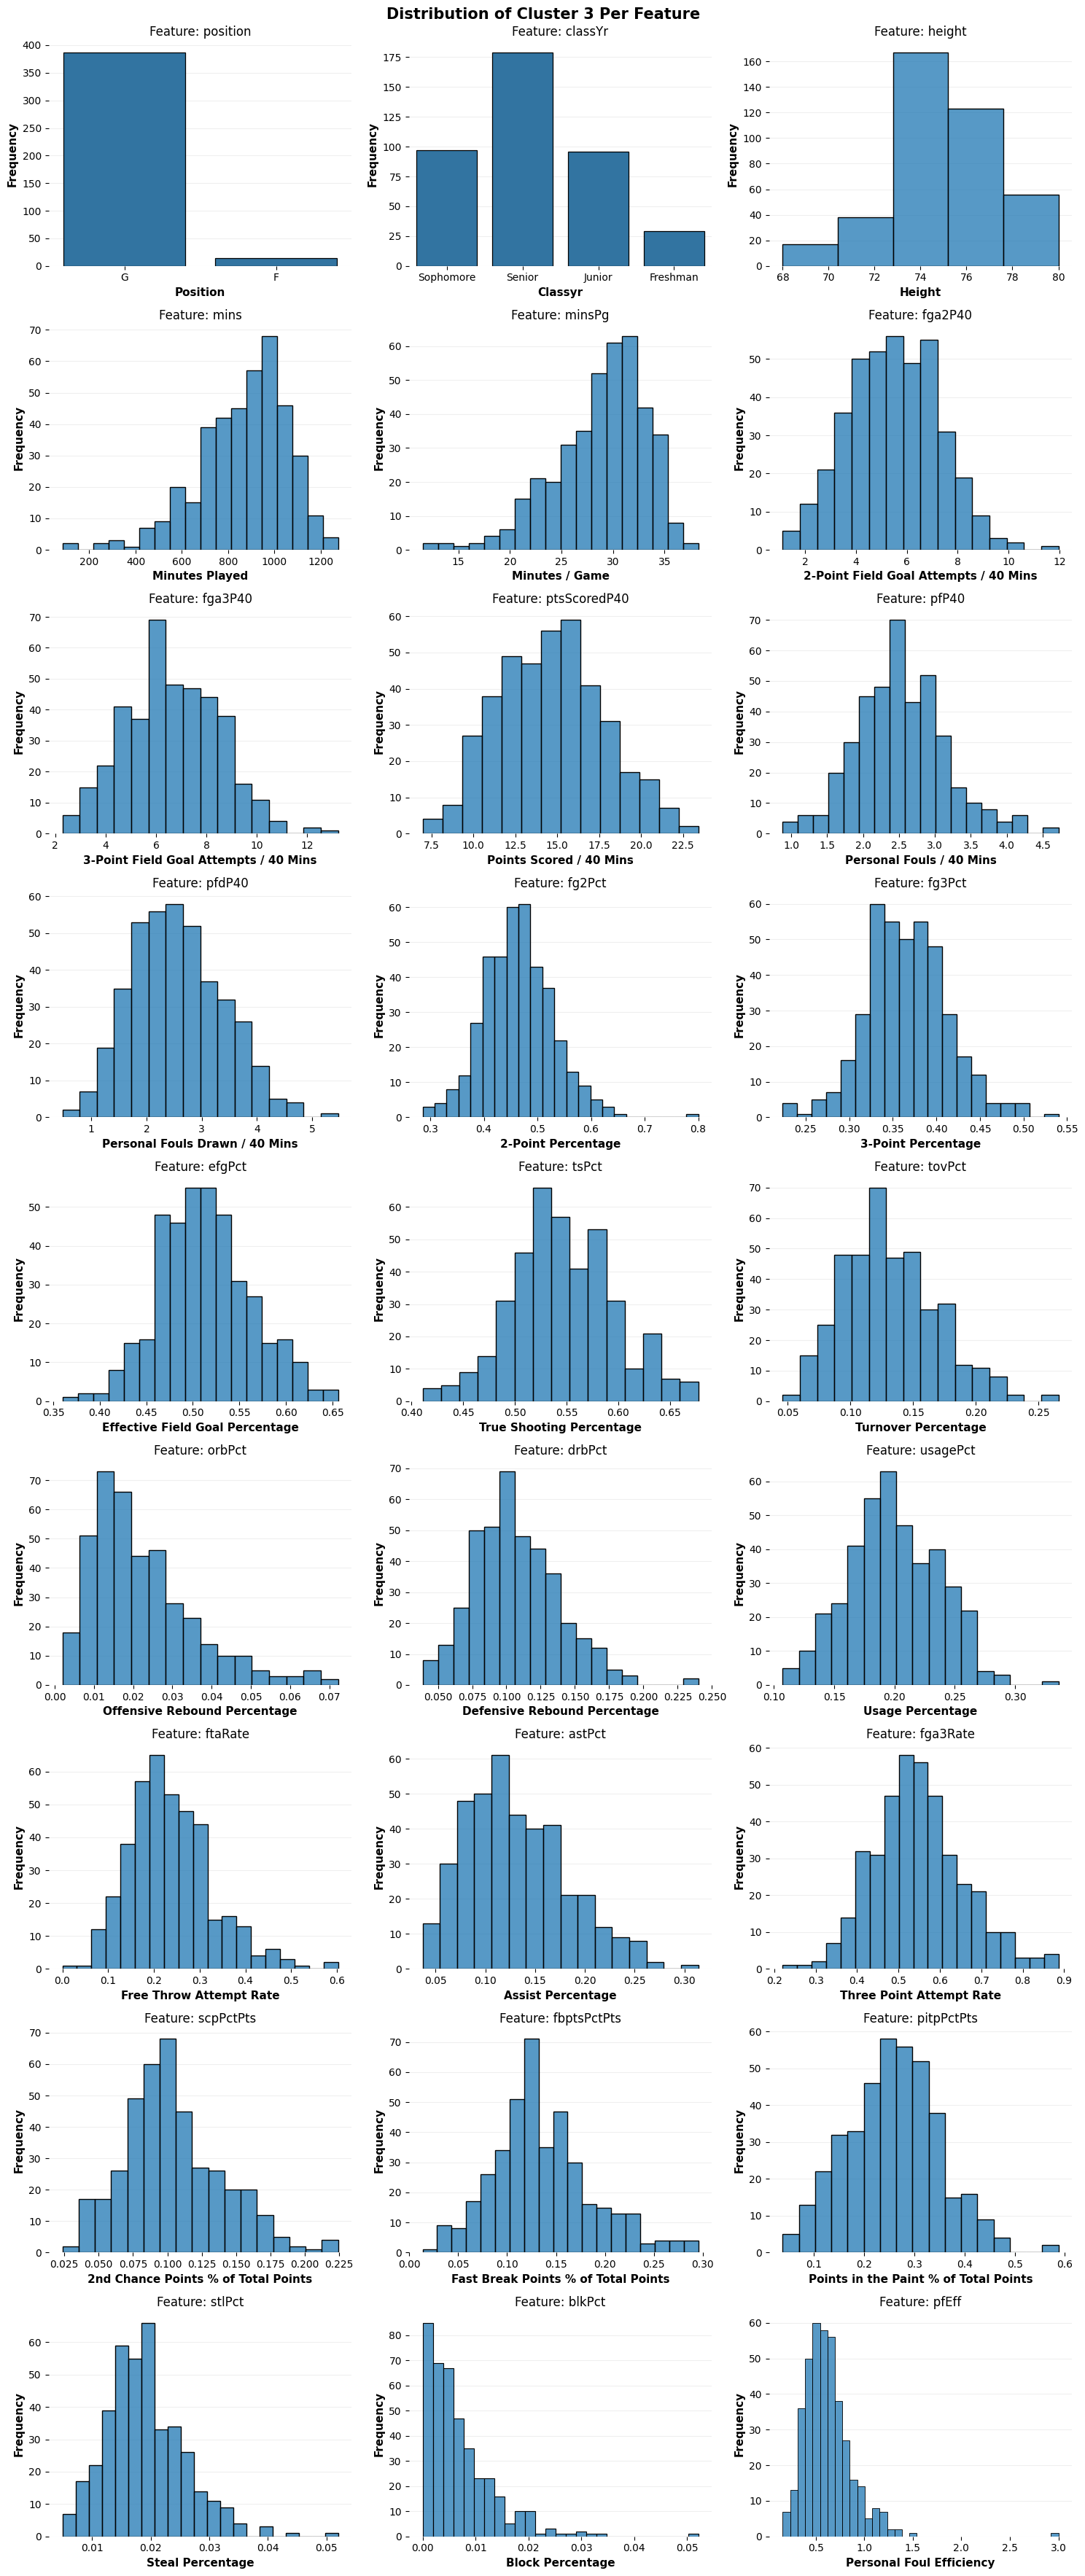

In [54]:
create_kmeans_histogram(kmeans_df, cluster_num = 3)

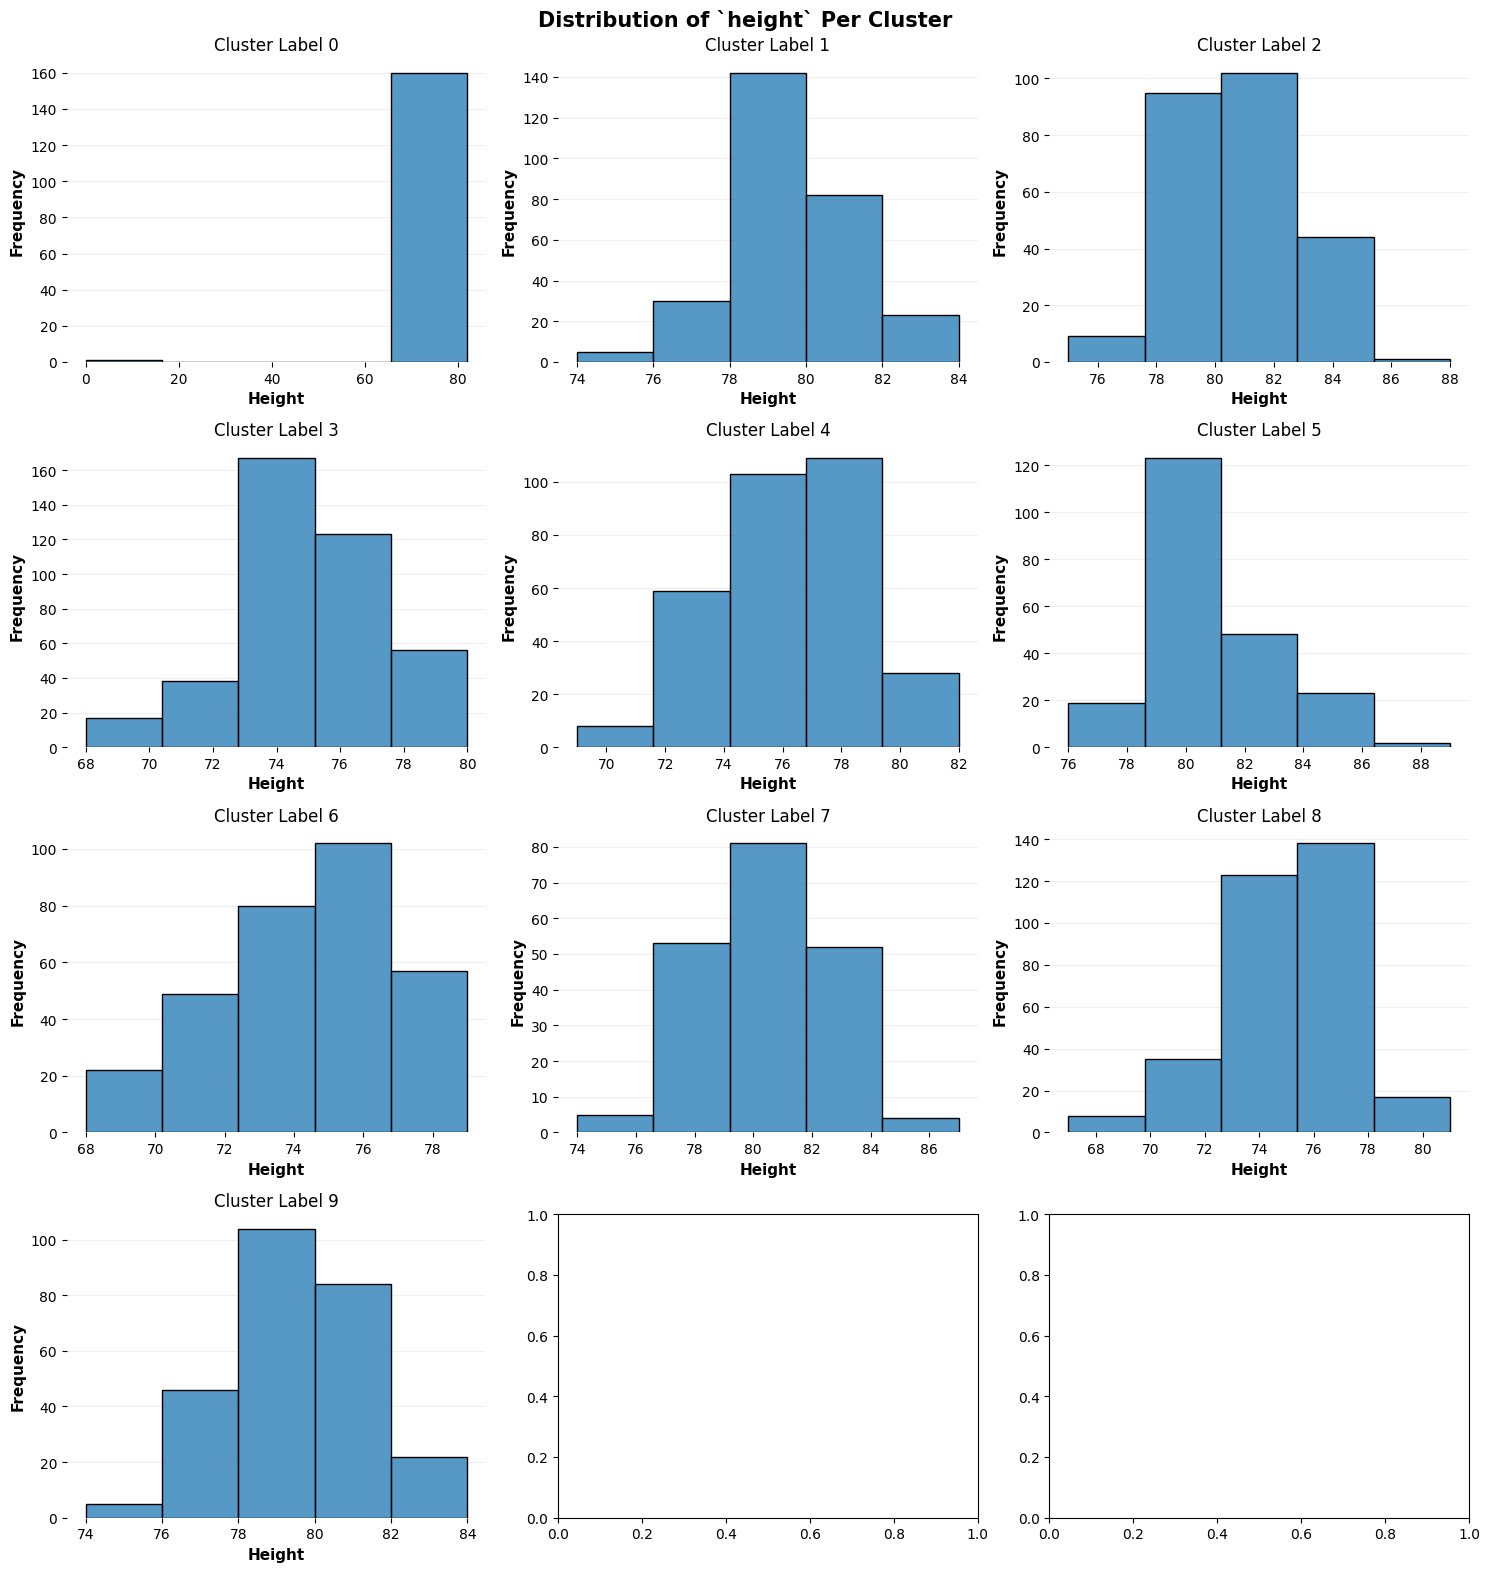

In [55]:
# another variation of above histogram: distribution of a specified feature across each cluster
create_kmeans_histogram(kmeans_df, col_name = 'height')

In [56]:
# for the purpose of our dotplot, let's drop our categorical features since they don't make sense in this case
kmeans_dotplot_df = standardized_kmeans_df.drop(columns = ['position', 'classYr'])
kmeans_dotplot_df

,height,mins,minsPg,fga2P40,fga3P40,ptsScoredP40,pfP40,pfdP40,fg2Pct,fg3Pct,efgPct,tsPct,tovPct,orbPct,drbPct,usagePct,ftaRate,astPct,fga3Rate,scpPctPts,fbptsPctPts,pitpPctPts,stlPct,blkPct,pfEff,Label
playerId,,,,,,,,,,,,,,,,,,,,,,,,,,
967231,0.738,-0.148,0.730,0.918,-1.224,-0.203,0.232,1.196,0.039,-0.414,-0.130,-0.360,1.109,0.123,0.640,0.453,0.566,0.718,-1.309,-0.135,-1.054,1.135,-0.834,1.301,0.163,5
1947715,-1.458,-0.991,-1.018,-0.915,-1.083,-1.867,-0.037,-1.971,-0.389,-0.121,-0.625,-0.984,1.147,-0.590,-1.298,-1.848,-0.883,-0.069,-0.716,-0.393,0.993,0.611,1.808,-0.689,0.287,8
1687493,-0.909,-0.839,-0.669,-1.022,0.164,-0.908,0.837,0.311,-1.295,0.418,-0.576,-0.483,1.149,-0.587,-1.094,-0.588,-0.096,1.190,0.793,0.087,0.959,-0.966,0.452,-0.862,-0.969,8
1914079,0.189,-1.062,0.089,-0.019,-0.293,-0.271,1.598,0.003,0.651,-1.293,-0.595,-0.366,-0.234,0.660,-0.939,-0.102,0.626,-0.341,-0.182,0.717,1.026,0.781,-0.783,-0.494,-1.378,8
1914087,-0.086,-1.093,-0.968,-0.088,-1.378,-0.772,1.434,0.764,0.805,-2.466,0.739,0.232,0.150,1.417,-0.506,-0.950,2.184,-1.384,-1.455,2.961,-0.135,1.566,-0.437,0.573,-0.765,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331908,-0.634,1.479,1.523,-0.143,1.055,0.815,-1.179,0.166,0.054,0.481,0.248,0.403,-0.305,-0.914,-1.211,0.920,-0.315,1.689,0.683,-0.670,-1.094,-1.070,-0.169,-0.677,0.263,3
1614955,-2.007,1.445,1.482,1.187,0.718,1.561,-0.826,0.578,0.469,-0.030,0.084,0.235,-0.069,-0.930,-0.027,1.923,-0.431,1.506,0.011,-0.484,0.300,0.043,-0.460,-0.718,-0.466,6
1933824,-0.086,0.848,0.756,-0.201,0.777,1.031,-0.878,0.150,0.513,0.792,0.860,1.165,-0.587,-0.836,0.695,0.531,0.102,-0.448,0.586,-0.308,-0.601,-0.507,-0.669,-0.804,-0.691,1


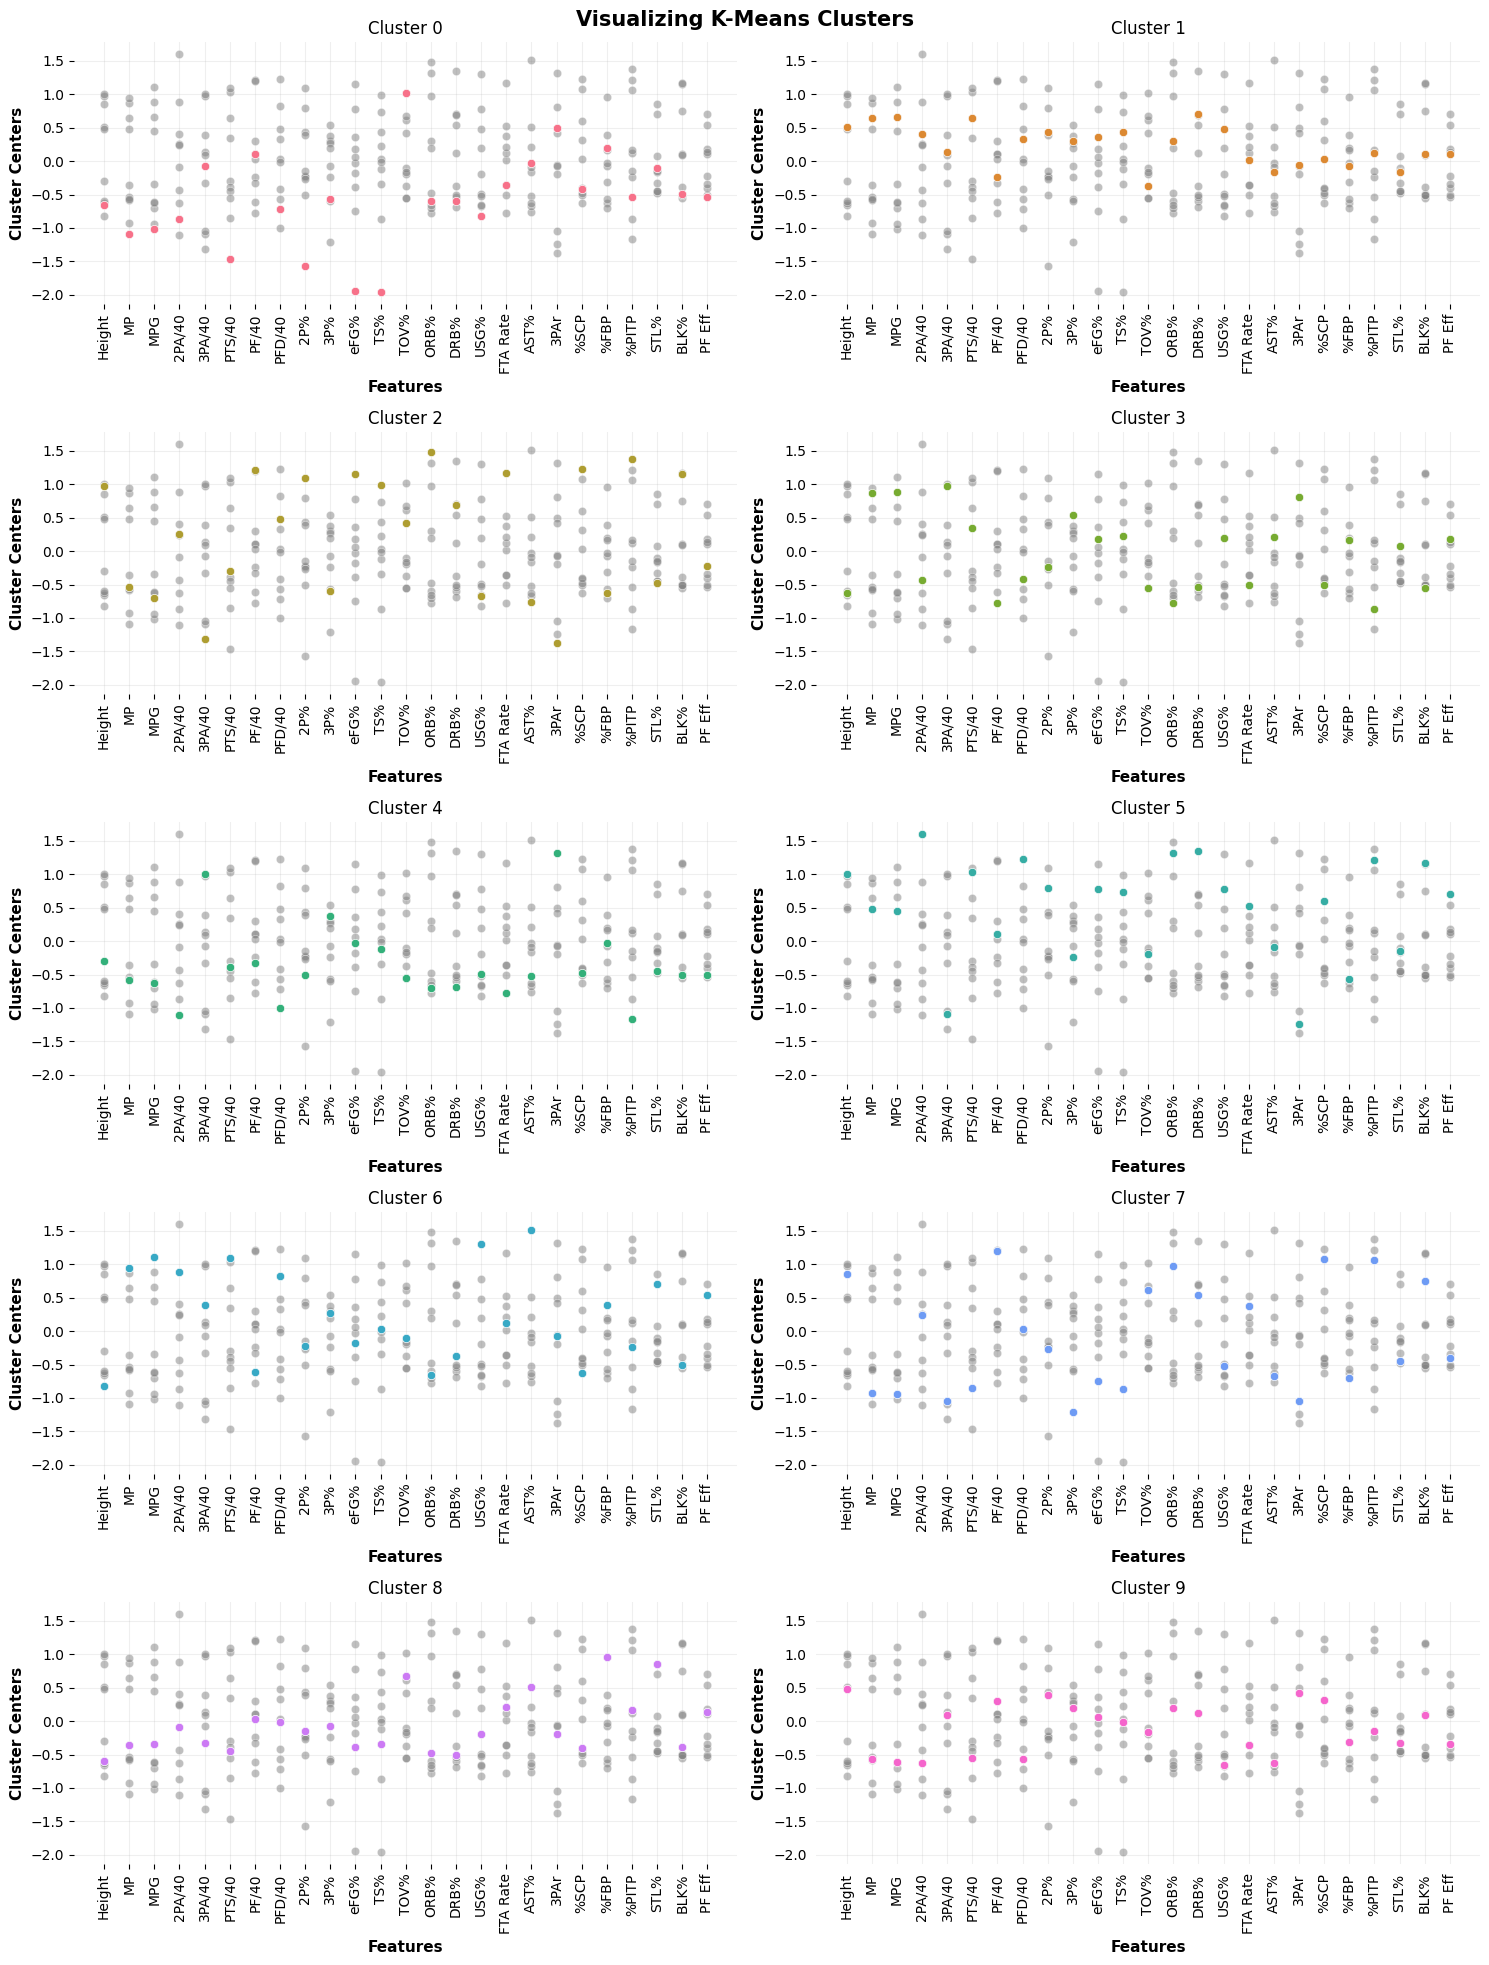

In [57]:
# this graph shows each cluster does on average in comparison to the other clusters for each feature
create_kmeans_cluster_dotplot(kmeans_dotplot_df)

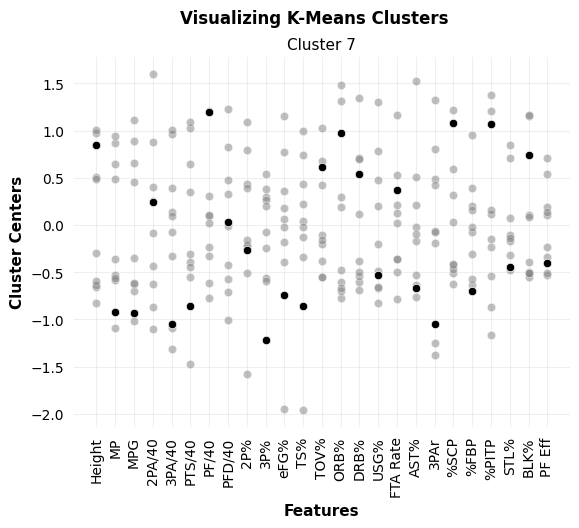

In [58]:
# this graph is a different variation of the previous, if you put in the cluster_num it will only output that cluster, vs the previous graph shows all the clusters highlighted
create_kmeans_cluster_dotplot(kmeans_dotplot_df, 7)

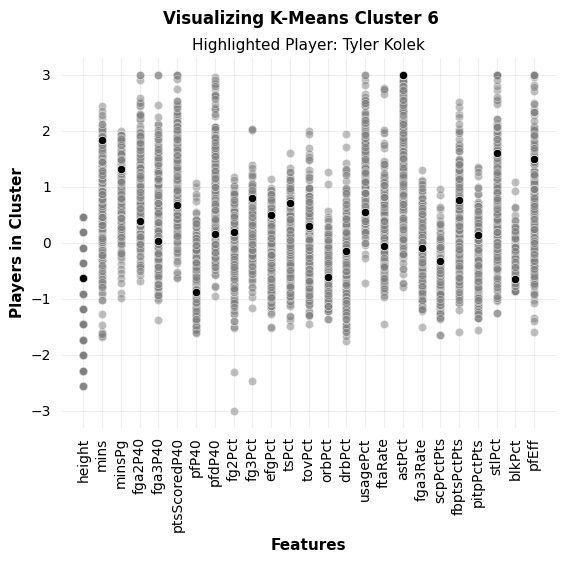

In [59]:
# lastly, this is similar to the last two graphs, but this shows how a player does in comparison to the cluster they're in, so it shows individual player performance
create_kmeans_player_dotplot(kmeans_df = kmeans_dotplot_df, og_df = all_player_stats_df, player_id = 1599828)

# KNN Model

The second machine learning algorithm we will use is K-Nearest Neighbors (KNN). KNN uses Euclidean distance to find the closest points to the target, which can tell us which players are the most similar. This can be very useful in basketball scouting to find players of similar attributes to fill skills in a team.



In [63]:
# Using KNN, this function outputs the n most similar players to the player ID inputted
get_knn_similar_players(all_player_stats_df, player_stats_df__standardized, 1599828, 10)

,search_id,search_name,rec_number,rec_id,rec_name,distance_score
14570,1599828,Tyler Kolek,1,1599429,Stephan Swenson,0.056
14571,1599828,Tyler Kolek,2,1587082,Jamal Shead,0.056
14572,1599828,Tyler Kolek,3,934179,Tucker Richardson,0.064
14573,1599828,Tyler Kolek,4,967249,Sam Sessoms,0.069
14574,1599828,Tyler Kolek,5,1916851,Cason Wallace,0.073
14575,1599828,Tyler Kolek,6,1607784,Reece Beekman,0.073
14576,1599828,Tyler Kolek,7,1319801,Damion Baugh,0.074
14577,1599828,Tyler Kolek,8,1311661,Yuri Collins,0.075
14578,1599828,Tyler Kolek,9,1310779,Jaylin Hunter,0.077
14579,1599828,Tyler Kolek,10,1611582,Colby Jones,0.080


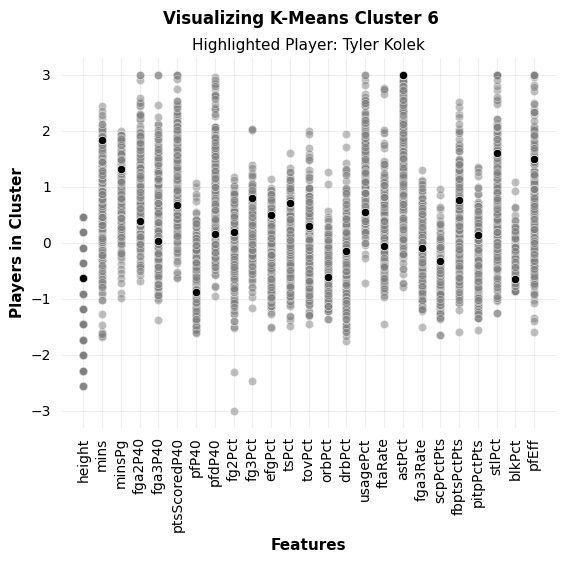

In [64]:
create_kmeans_player_dotplot(kmeans_df = kmeans_dotplot_df, og_df = all_player_stats_df, player_id = 1599828)

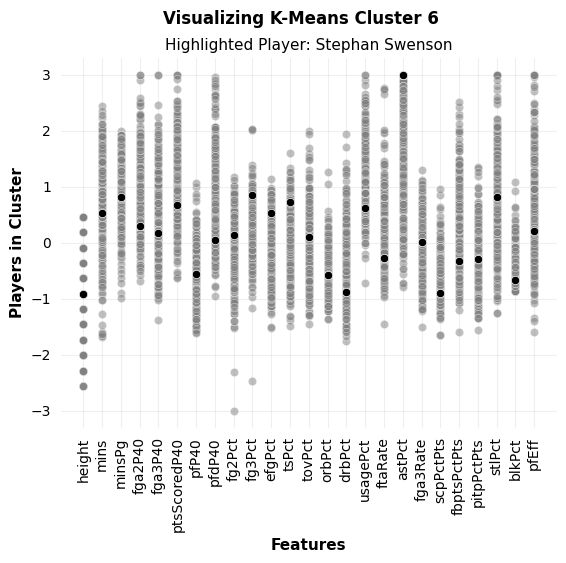

In [68]:
create_kmeans_player_dotplot(kmeans_df = kmeans_dotplot_df, og_df = all_player_stats_df, player_id = 1599429)

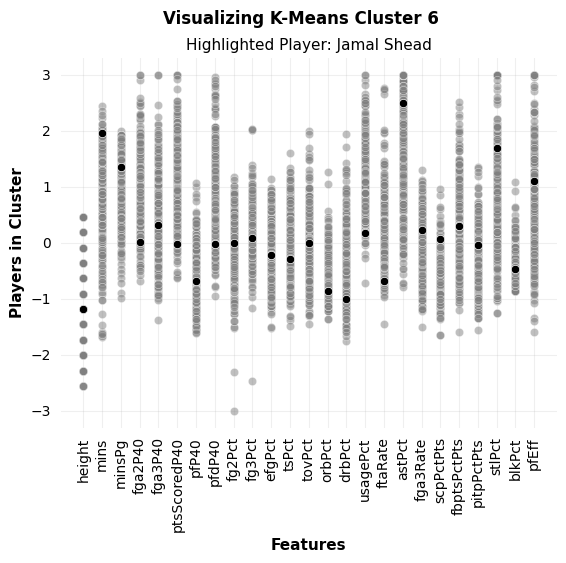

In [69]:
create_kmeans_player_dotplot(kmeans_df = kmeans_dotplot_df, og_df = all_player_stats_df, player_id = 1587082)

While KNN listed Stephan Swenson and Jamal Shead as the top 2 players the most similar to Tyler Kolek, our K-Means model grouped these players all in the same cluster as well. We can use our K-Means and KNN models to cross-reference results to help achieve our analytical goals.

From these dot plots, we can see that these players have very similar player statistics, indicating that they have similar roles and qualities as a player. All three players are:
1. Average height
2. Top assist percentages
3. Low block percentage
4. Lower end of field goal attempts

With all of these attributes it seems that these players help facilitate ball movement and assisting their teammates rather than being primary scorers or defensive players. They help with offense by distributing the ball and keeping the game flowing.

While I only scratched the surface of these findings, there is much potential using machine learning techniques to deepen our understanding of player statistics in basketball. We can unlock invaluable insights into player performance, team dynamics, and strategies.